In [1]:
using Plots, Random, Distributions, StatsBase, Printf, LaTeXStrings, 
    DataFrames, StatsPlots, KernelDensity, LinearAlgebra
default(fillcolor=:lightgrey, markercolor=:black, markersize=2,
    grid=false, legend=false, titlefontsize=10)

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1423


# Data Augmentations

## Mixture of Gaussians

We consider data $Y_1, \ldots, Y_n$, each of whic hcan come from one of the $K$ population. The distribution of $Y_i$ in the $k^{th}$ population is $N(\mu_k, 1/{\tau})$. We do not observe from which population each $Y_i$ come from. It is distribution is given by a *mixture distibution*:
$$\sum_{k = 1}^{K}\pi_k\phi_k(y_i)$$
Where $pi_k$ is the probability of belonging to population $k$ and $\phi_k$ is the density of $N(\mu_k, 1/ {\tau})$. For simplicity we assume that $\tau$ is known and common for all components of the mixture.

Priors:
$$
\begin{aligned}
\mu_k \sim N(\mu_0, 1/\tau_0) \\
(\pi_1, \ldots, \pi_K) &\sim Dir(\alpha_1, \ldots, \alpha_K)
\end{aligned}
$$

We introduce auxilary variables $Z_1, \ldots, Z_n$ indicating which population the $i$-th individuals come from.
$$\mathbb{P}(Z_i = k) = \pi_k \quad \text{ and } \quad  Y_i | Z_i \sim N(\mu_k, 1/\tau) $$

Posteriors:
$$
\begin{aligned}
\mathbb{P}(Z_i = k | Y_1, \ldots, Y_n, \mu_1, \ldots, \mu_K, \pi_1, \ldots, \pi_K) 
&= \frac{\pi_k\phi_k(y_i)}{\sum_{l=1}^{K}\pi_l\phi_l(y_i)} \\
\mu_k | Y_1, \ldots, Y_n, Z_1, \ldots, Z_n, \pi_1, \ldots, \pi_K 
&\sim N\left(\frac{\tau\left(\sum_{Z_i = k}y_i\right)+ \tau_0\mu_0}{\tau|\{i: Z_i = k\}| + \tau_0}, 
\frac{1}{\tau|\{i: Z_i = k\}| + \tau_0}\right) \\ 
\pi_1, \ldots, \pi_K | Y_1, \ldots, Y_n, Z_1, \ldots, Z_n, \mu_1, \ldots, \mu_K 
&\sim Dir\left(\alpha_1 + |\{i: Z_i = 1\}|, \ldots, \alpha_K + |\{i: Z_i = K\}|\right)
\end{aligned}
$$

### Simulated data

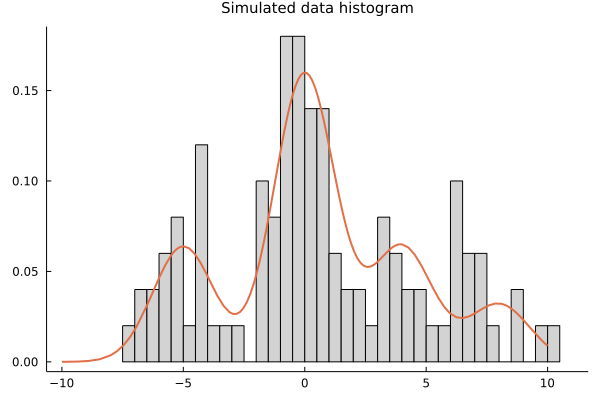

In [10]:
# parameters
mu = [-5, 0, 4, 8]
tau = 0.8
pi = [0.2, 0.5, 0.2, 0.1]
K = length(pi)
N = 100

# data simulation
Y = zeros(0)
for i in range(1, K)
    append!(Y, rand(Normal(mu[i], 1/tau), Int(N * pi[i])))
end;

# plot the histogram and the pdf
function f(x, pi, mu, tau)
    y = 0
    K = length(pi)
    for i in range(1, K)
        y += pi[i] * pdf(Normal(mu[i], 1/tau), x)
    end
    y
end

g(x) = f(x, pi, mu, tau)
histogram(Y, bins=50, normed=true, title="Simulated data histogram")
plot!(g, -10, 10, width=2)

### Gibs sampler for a Gaussian mixture

In [11]:
function draw_Z(y; mu, pi, tau)
    K = length(pi)
    p = zeros(K)
    for i in range(1, K)
        p[i] = pdf(Normal(mu[i], 1/tau), y) * pi[i]
    end
    p = p ./ sum(p)
    sample([1:1:K;], Weights(p))
end

function mix_gibbs_sample(;data, alpha0, tau0, mu0, N_iter=1000)
    Y = data
    K = length(alpha0)
    prior_pi = Dirichlet(alpha0)
    prior_mu = Normal(mu0, 1/tau0)  # the same prior for all mixtures
    n = length(Y)  # number of data points
    col_mu = [1:1:K;]
    col_pi = [K+1:1:2*K;]
    X = Array{Float64, 2}(undef, N_iter, 2*K)

    # draw starting values
    X[1, col_mu] = sort(rand(prior_mu, K))
    X[1, col_pi] = rand(prior_pi)

    for t in range(2, N_iter)
        # draw Z1, ..., Zn
        Z = draw_Z.(Y, mu=X[t - 1, col_mu], pi=X[t - 1, col_pi], tau=tau)
        # draw mu1, ..., muK
        cts = [sum(Z .== k) for k in range(1, K)]
        new_mu = zeros(K)
        for k in range(1, K)
            tau_k = (cts[k] * tau + tau0)
            new_mu[k] = sum(Y[Z .== k]) * tau + tau0*mu0
            new_mu[k] = new_mu[k] / tau_k
            X[t, k] = rand(Normal(new_mu[k], 1 / tau_k))
        end
        # draw pi1, ..., piK
        X[t, col_pi] = rand(Dirichlet(alpha0 .+ cts))
        X
    end
    X
end;

In [12]:
N_iter = 1000
alpha0 = fill(1, K)
tau0 = 0.5
mu0 = 0
X = mix_gibbs_sample(data=Y, alpha0=alpha0, tau0=tau0, mu0=mu0, N_iter=N_iter)
col_mu = [1:1:K;]
col_pi = [K+1:1:2*K;];

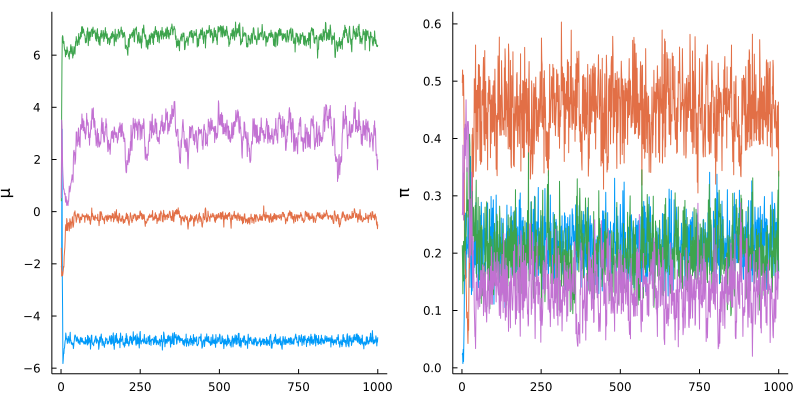

In [13]:
# trace plots
plot(X[:, col_mu], layout = (1,2), size = (800, 400), subplot=1, ylab="\\mu")
plot!(X[:, col_pi], subplot=2, ylab="\\pi")

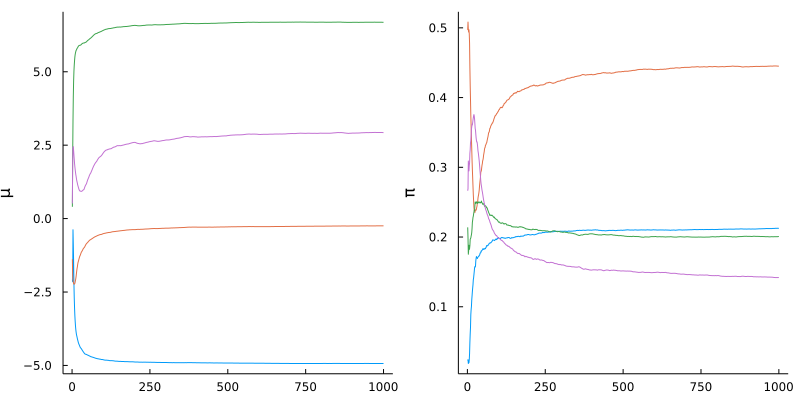

In [14]:
# ergodic averages
Z = cumsum(X, dims=1) ./ [1:1:N_iter;]
plot(Z[:, col_mu], layout = (1,2), size = (800, 400), subplot=1, ylab="\\mu")
plot!(Z[:, col_pi], subplot=2, ylab="\\pi")

In [15]:
println("Estimated means:", round.(Z[N_iter, col_mu], digits=2))
println("Estimated probabilities:", round.(Z[N_iter, col_pi], digits=2))

println("True means:", mu)
println("Ture probabilities:", pi)

Estimated means:[-4.93, -0.25, 6.68, 2.93]
Estimated probabilities:[0.21, 0.44, 0.2, 0.14]
True means:[-5, 0, 4, 8]
Ture probabilities:[0.2, 0.5, 0.2, 0.1]


## The Ising Model

The Ising model specifies a probability distribution over the possible values {-1, +1} that each vertex $x_i$ in a lattice graph can take:
$$f(x_1, \ldots, x_m) = \frac{1}{Z}\exp{\left(J\sum_{(i, j) \in \mathcal{E}}{x_ix_j}\right)}$$

### Simple Gibbs Sampler
We can implement a simple Gibbs Sampler by noting that the full conditional distributions are given by:
$$f_{X_j | X_{-j}}(x_j | x_{-j}) = \exp{\left(J\sum_{i\sim j}{x_ix_j}\right)} / \left[ \exp{\left(-J\sum_{i\sim j}{x_i}\right)} + \exp{\left(J\sum_{i\sim j}{x_i}\right)} \right]$$

In [80]:
function sample_node(i, j, G, J)
    neighbours = [G[i, j+1] G[i, j-1] G[i+1, j] G[i-1, j]]
    num = exp(J * sum(neighbours))
    denom = exp(-J * sum(neighbours)) + exp(J * sum(neighbours))
    p = num / denom  # probability of +1
    q = 1 - p
    sample([1, -1], Weights([p, q]))
end

function ising_simple_gibbs(J, M, N_iter=100)
    # initialise the graph with ones and zeros on borders
    G = convert(Matrix{Int32}, zeros(M + 1, M + 1))
    for i in range(2, M)
        for j in range(2, M)
            G[i, j] = 1
        end
    end
    
    # sample
    for t in range(2, N_iter)
        for i in range(2, M)
            for j in range(2, M)
                G[i, j] = sample_node(i, j, G, J)
            end
        end
    end
    G[2:M, 2:M]
end

ising_simple_gibbs (generic function with 2 methods)

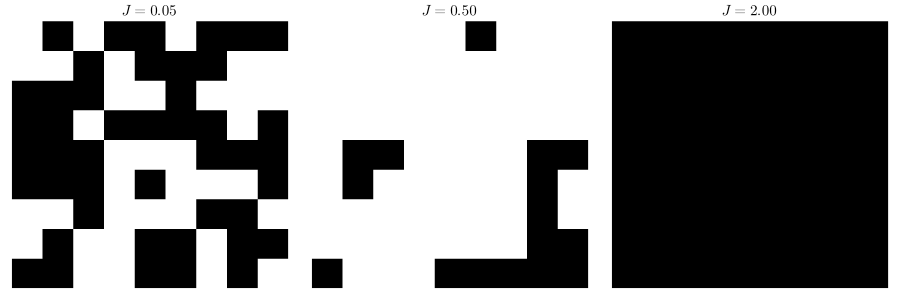

In [97]:
G1 = ising_simple_gibbs(0.05, 10)
G2 = ising_simple_gibbs(0.5, 10)
G3 = ising_simple_gibbs(2, 10)

default(legend=false, xticks=false, yticks=false, xaxis=false, 
    yaxis=false, fillcolor=:binary, titlefontsize=10)
heatmap(G1, size=(900,300), subplot=1, layout = (1,3), title=L"J=0.05")
heatmap!(G2, subplot=2, title=L"J=0.50")
heatmap!(G3, subplot=3, title=L"J=2.00")

When $J$ (relative to the size of the graph) is large, the vcorrelation between the adjacent states within the Ising model causes the Gibbs sampler to mix slowly.  The chain with $J=0.05$ has reached a state with littele in common with its starting vlaue, while that with $J=2.00$ has hardly moved from the starting values after 100th iteration.

### The Swendsen-Wang Algorithm